Тестовое задание ЭКОПСИ. Аналитик данных. Тест 2. Сергей Ершов mail-to: ershov@ngs.ru

Описание данных  
Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест.  
Задание  
•	Часть строк по доходу не заполнена, заполните их  
•	Выявите формулу дохода в целом и его составных частей  
•	Проверьте, что данная формула объясняет доход с точностью до копейки  
•	Выявите зависимости между составными частями дохода  

Пришлите нам:  
•	Итоговую формулу дохода в теле письма или в Word  
•	Базу со всеми доходами в Excel  
Подсказка:  
Доход состоит из оклада, премии и двух видов доплат и индивидуальных надбавок

План выполнения задания:
1. Подготовка
Загрузка данных из он-лайн хранилища  
Предобработка данных  
Выделение строк NaN в поле "Доход" в Тестовый дата-сет  
Оставшиеся строки используем в качестве Тренировочного дата-сета df_train
Проведём EDA  

2. Решение  
Разделим тренировочную выборку в соотношении 20:80  
Из библиотеки skilearn прогоним разные ML алгоритмы  
Оценим лучший по характеристикам MAE, MSE, MAPE, R2  
Обучим по модели с учителем через поиск регрессии   
Получим вектор Y, применим к тестовой выборке  

3. Выводы

In [317]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import datasets, linear_model, metrics

from pandas import ExcelWriter

sns.set()

In [285]:
data = pd.read_excel('task_2.xlsx')
data.head()


,ID,FIO,Профессия,Разряд,Оборудование,Класс вредности,Месяц,Отработанные часы,Объем производства,Доход (руб.)
0,1,Журавлев Б. И.,Уборщик,2,Вспомогательные помещения,1.0,2022-01-01,180,1950,NaN
1,2,Степанов А. М.,Уборщик,2,Вспомогательные помещения,1.0,2022-01-01,228,1950,NaN
2,3,Федотов М. М.,Уборщик,2,Вспомогательные помещения,1.0,2022-01-01,252,1950,NaN
3,4,Абрамов Е. Д.,Уборщик,2,Пилигримовые станы,3.3,2022-01-01,240,1950,NaN
4,5,Волков Д. М.,Подручный вальцовщика,2,Пилигримовые станы,3.3,2022-01-01,252,1950,NaN


In [286]:
data = data.rename(columns={'ID':'id_old', 'FIO':'fio', 'Профессия':'prof', 'Разряд':'skill', 'Оборудование':'equip', 'Класс вредности':'hazard', 'Месяц':'month', 'Отработанные часы':'hours', 'Объем производства':'production', 'Доход (руб.)':'salary'})
data.head(1)

,id_old,fio,prof,skill,equip,hazard,month,hours,production,salary
0,1,Журавлев Б. И.,Уборщик,2,Вспомогательные помещения,1.0,2022-01-01,180,1950,NaN


In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_old      2400 non-null   int64         
 1   fio         2400 non-null   object        
 2   prof        2400 non-null   object        
 3   skill       2400 non-null   int64         
 4   equip       2400 non-null   object        
 5   hazard      2400 non-null   float64       
 6   month       2400 non-null   datetime64[ns]
 7   hours       2400 non-null   int64         
 8   production  2400 non-null   int64         
 9   salary      1551 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 187.6+ KB


In [288]:
display(data['prof'].unique())
len(data['prof'].unique())

array(['Уборщик', 'Подручный вальцовщика', 'Оператор поста управления',
       'Нагревальщик металла', 'Посадчик металла', 'Огнеупорщик',
       'Резчик горячего металла', 'Вальцовщик',
       'Контролер качества готовой продукции'], dtype=object)

9

In [289]:
display(data['skill'].unique())
len(data['skill'].unique())

array([2, 3, 4, 5, 6, 7, 8], dtype=int64)

7

In [290]:
# prof_dum = pd.get_dummies(data['prof'])
# prof_dum.head()
# pd.concat(data, prof_dum, axis=1)
# data.head(2)


In [291]:
display(data['equip'].unique())
len(data['equip'].unique())

array(['Вспомогательные помещения', 'Пилигримовые станы',
       'Калибровочный стан', 'Нагревательные печи', 'Прошивной стан',
       'Калибровочный стан, ГРП', 'Нагревательные печи, кантовка',
       'Нагревательные печи, нагрев',
       'Контрольно-измерительная аппаратура'], dtype=object)

9

In [292]:
data = pd.get_dummies(data, columns=['prof', 'equip'], prefix=['prof', 'equip'], dtype='int64')
print(data.columns.tolist())
data.head(2)

['id_old', 'fio', 'skill', 'hazard', 'month', 'hours', 'production', 'salary', 'prof_Вальцовщик', 'prof_Контролер качества готовой продукции', 'prof_Нагревальщик металла', 'prof_Огнеупорщик', 'prof_Оператор поста управления', 'prof_Подручный вальцовщика', 'prof_Посадчик металла', 'prof_Резчик горячего металла', 'prof_Уборщик', 'equip_Вспомогательные помещения', 'equip_Калибровочный стан', 'equip_Калибровочный стан, ГРП', 'equip_Контрольно-измерительная аппаратура', 'equip_Нагревательные печи', 'equip_Нагревательные печи, кантовка', 'equip_Нагревательные печи, нагрев', 'equip_Пилигримовые станы', 'equip_Прошивной стан']


,id_old,fio,skill,hazard,month,hours,production,salary,prof_Вальцовщик,prof_Контролер качества готовой продукции,...,prof_Уборщик,equip_Вспомогательные помещения,equip_Калибровочный стан,"equip_Калибровочный стан, ГРП",equip_Контрольно-измерительная аппаратура,equip_Нагревательные печи,"equip_Нагревательные печи, кантовка","equip_Нагревательные печи, нагрев",equip_Пилигримовые станы,equip_Прошивной стан
0,1,Журавлев Б. И.,2,1.0,2022-01-01,180,1950,NaN,0,0,...,1,1,0,0,0,0,0,0,0,0
1,2,Степанов А. М.,2,1.0,2022-01-01,228,1950,NaN,0,0,...,1,1,0,0,0,0,0,0,0,0


In [293]:
 col_prof = ['prof_Вальцовщик', 'prof_Контролер качества готовой продукции', 'prof_Нагревальщик металла', 'prof_Огнеупорщик', 'prof_Оператор поста управления', 'prof_Подручный вальцовщика', 'prof_Посадчик металла', 'prof_Резчик горячего металла', 'prof_Уборщик']
 data['prof_ohe'] = data[col_prof].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
 data.drop(['prof_Вальцовщик', 'prof_Контролер качества готовой продукции', 'prof_Нагревальщик металла', 'prof_Огнеупорщик', 'prof_Оператор поста управления', 'prof_Подручный вальцовщика', 'prof_Посадчик металла', 'prof_Резчик горячего металла', 'prof_Уборщик'], axis=1, inplace=True)
 col_equip = ['equip_Вспомогательные помещения', 'equip_Калибровочный стан', 'equip_Калибровочный стан, ГРП', 'equip_Контрольно-измерительная аппаратура', 'equip_Нагревательные печи', 'equip_Нагревательные печи, кантовка', 'equip_Нагревательные печи, нагрев', 'equip_Пилигримовые станы', 'equip_Прошивной стан']
 data['equip_ohe'] = data[col_equip].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
 data.drop(['equip_Вспомогательные помещения', 'equip_Калибровочный стан', 'equip_Калибровочный стан, ГРП', 'equip_Контрольно-измерительная аппаратура', 'equip_Нагревательные печи', 'equip_Нагревательные печи, кантовка', 'equip_Нагревательные печи, нагрев', 'equip_Пилигримовые станы', 'equip_Прошивной стан'], axis=1, inplace=True)
 
 data.head(2)

,id_old,fio,skill,hazard,month,hours,production,salary,prof_ohe,equip_ohe
0,1,Журавлев Б. И.,2,1.0,2022-01-01,180,1950,NaN,000000001,100000000
1,2,Степанов А. М.,2,1.0,2022-01-01,228,1950,NaN,000000001,100000000


In [294]:
display(data['hazard'].unique())
len(data['hazard'].unique())

array([1. , 3.3, 2. , 3.4, 3.1, 3.2])

6

In [295]:
# добавим метрику производительности труда
data['prod_ty']=data['production']/data['hours']

In [296]:
data.describe()

,id_old,skill,hazard,month,hours,production,salary,prod_ty
count,2400.000000,2400.000000,2400.000000,2400,2400.000000,2400.000000,1551.000000,2400.000000
mean,1200.500000,4.900000,2.934000,2022-06-16 12:00:00,192.400000,1595.833333,30211.722108,8.387490
min,1.000000,2.000000,1.000000,2022-01-01 00:00:00,72.000000,890.000000,8534.020000,5.555556
25%,600.750000,4.000000,3.175000,2022-03-24 06:00:00,168.000000,1452.500000,20821.740000,7.738095
50%,1200.500000,5.000000,3.300000,2022-06-16 00:00:00,192.000000,1560.000000,27207.670000,8.333333
75%,1800.250000,6.000000,3.325000,2022-09-08 12:00:00,216.000000,1825.000000,37477.220000,8.935185
max,2400.000000,8.000000,3.400000,2022-12-01 00:00:00,348.000000,2250.000000,76519.860000,12.361111
std,692.964646,1.676655,0.757881,NaN,46.512164,344.853385,12719.975479,0.900451


In [297]:
df_test = data[data['salary'].isna()]
len(df_test)

849

In [298]:
df_train = data[data['salary'].notna()]
len(df_train)

1551

In [299]:
len(df_test)/len(data)

0.35375

In [300]:
df_train.columns

Index(['id_old', 'fio', 'skill', 'hazard', 'month', 'hours', 'production',
       'salary', 'prof_ohe', 'equip_ohe', 'prod_ty'],
      dtype='object')

In [301]:
df_train_metrics = df_train[['skill', 'hazard', 'hours',
       'production', 'salary', 'prof_ohe', 'equip_ohe', 'prod_ty']]
df_train_metrics.head(2)

,skill,hazard,hours,production,salary,prof_ohe,equip_ohe,prod_ty
16,3,1.0,228,1950,28217.32,000000001,100000000,8.552632
17,3,1.0,240,1950,30488.47,000000001,100000000,8.125000


In [302]:
df_experiment_metrics = df_test[['id_old', 'skill', 'hazard', 'hours',
       'production', 'salary', 'prof_ohe', 'equip_ohe', 'prod_ty']]
df_experiment_metrics.head(2)

,id_old,skill,hazard,hours,production,salary,prof_ohe,equip_ohe,prod_ty
0,1,2,1.0,180,1950,NaN,000000001,100000000,10.833333
1,2,2,1.0,228,1950,NaN,000000001,100000000,8.552632


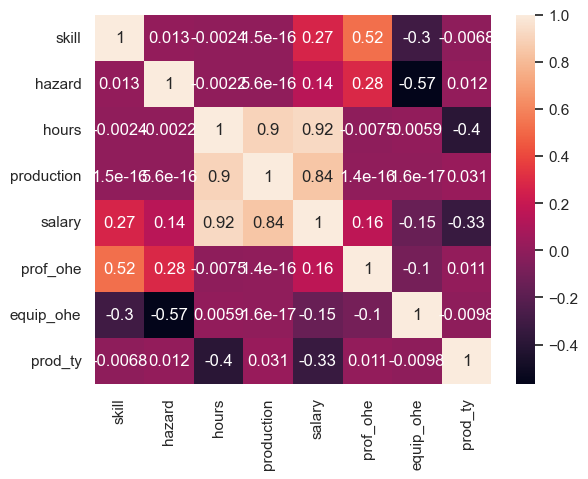

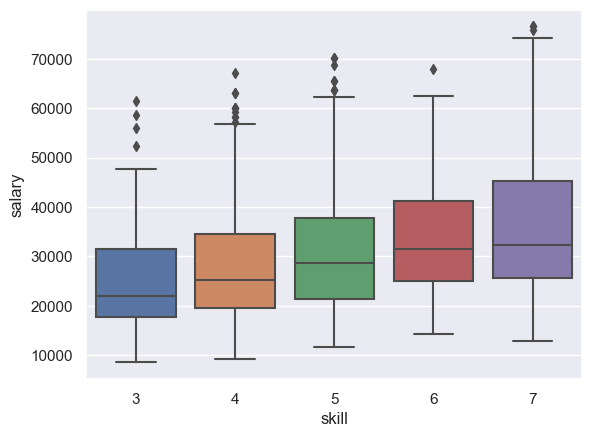

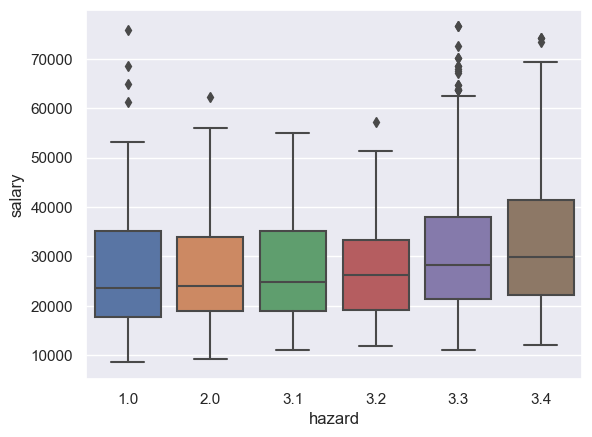

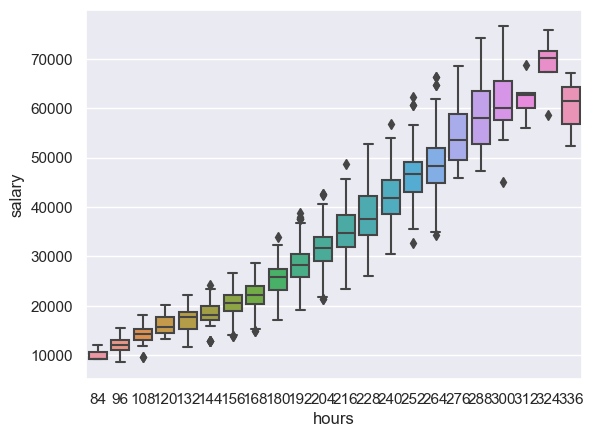

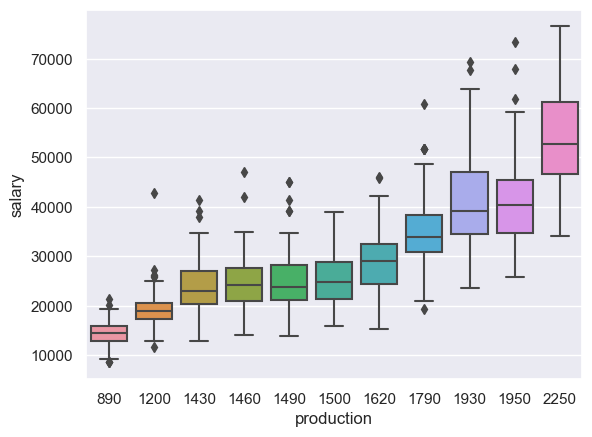

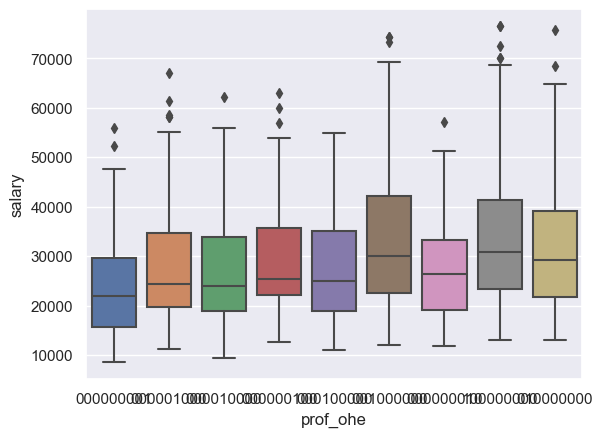

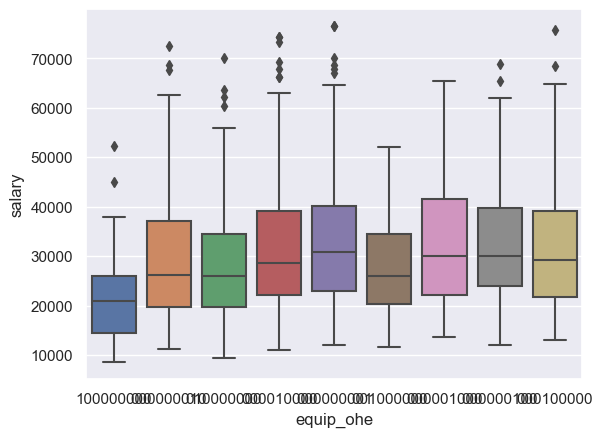

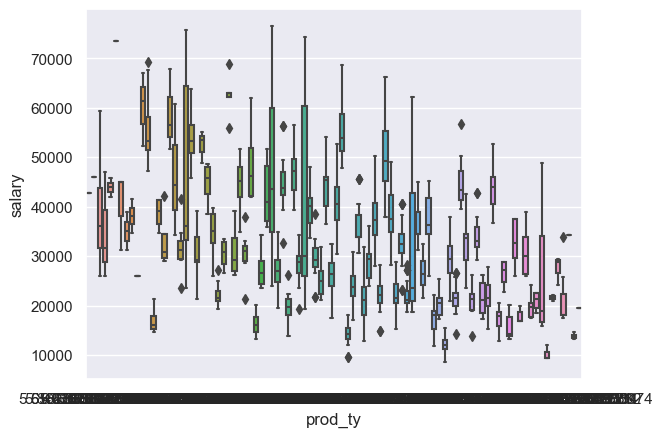

In [303]:
#построим и отрисуем матрицу корреляций
cm = df_train_metrics.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots()

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True)#ваш код здесь
ax.set_ylim(
    8, 0
)  # корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака

for col in df_train_metrics.drop('salary', axis=1).columns:
    # sns.scatterplot(x=df_train_metrics[col], y=df_train_metrics['salary'])
    sns.boxplot(x=df_train_metrics[col], y=df_train_metrics['salary'])
    plt.show()

### Вывод по предобработке
Ожидаемо, ключевыми факторами, влияющими на зарплату, являются отработанные часы и выпущенная продукция.  
Странно, что зарплата находится в обратно пропорциональной зависимости от производительности ))  
Выводы из тепловой карты подтверждаются "ящиками с усами", кроме двух ключевых факторов длинна усов довольно большая относительно второго квартиля.
Выбросы есть, но на первый взгляд они не критичны.

## 2. Решение

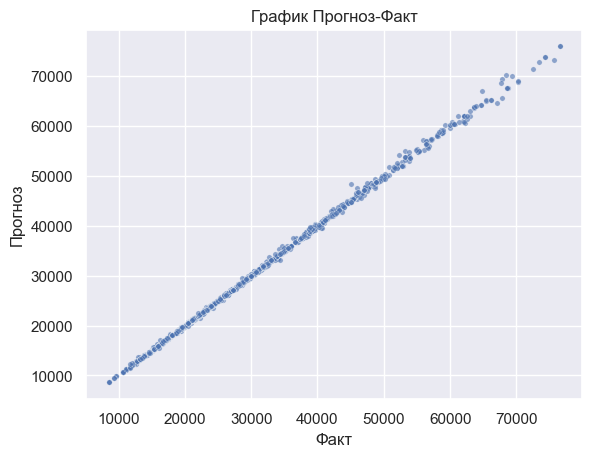

In [304]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df_train_metrics.drop('salary', axis=1)
y = df_train_metrics['salary']

# задаём алгоритм для модели 
model = RandomForestRegressor()

# обучим модель
model.fit(X, y) 

# сделаем прогноз обученной моделью
predictions = model.predict(X) 

# нарисуем график прогноз-факт
sns.scatterplot(x=y, y=predictions, s=15, alpha=0.6)
plt.title('График Прогноз-Факт')
plt.ylabel('Прогноз')
plt.xlabel('Факт')
plt.show()



Выделим валидационную выборку

Значение метрики R-квадрат:  0.9952343992203664


<Axes: xlabel='salary', ylabel='Density'>

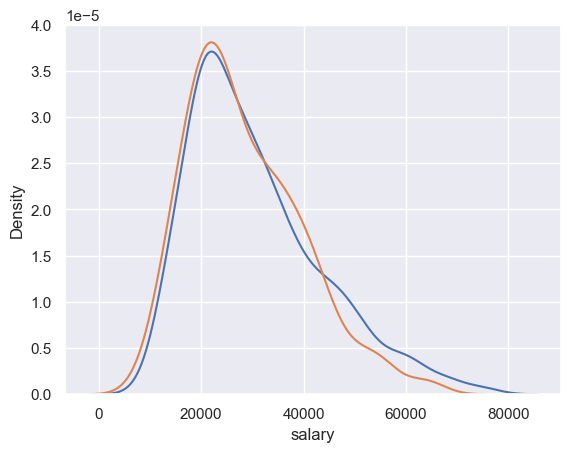

In [305]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df_train_metrics.drop('salary', axis=1)
y = df_train_metrics['salary']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# зададим алгоритм для нашей модели 
model = RandomForestRegressor(random_state=0) # задаём модель как элемент класса RandomForestRegressor (random_state=0)

# обучим модель
model.fit(X_train, y_train)# обучим вашу модель на обучающей выборке

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test)# сделаем прогноз для валидационной выборки с помощью вашей модели

# оценим метрику R-квадрат на валидационной выборке и напечатаем
r2 = r2_score(y_test, predictions)
print('Значение метрики R-квадрат: ', r2)
# гистограмма целевой переменной на train
sns.kdeplot(y_train)
# гистограмма целевой переменной на test
sns.kdeplot(y_test)

Отличный результат! Можно переходить к применению обученной модели на эксперементальную выборку.  
Но для демонстрации всего имеющегося арсенала, сначала сверим работу других алгоритмов.  

In [306]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df_train_metrics.drop('salary', axis=1)
y = df_train_metrics['salary']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# задайте список моделей
models = [
    Lasso(),
    Ridge(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
]

# функция, которая вычисляет MAPE
def mape(y_true, y_pred):
    y_error = y_true - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs / y_true
    mape = perc_error_abs.sum() / len(y_true)
    return mape


# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'MAE:{:.2f} MSE:{:.2f} MAPE:{:.2f} R2:{:.2f} '.format(
            mean_absolute_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred),
            mape(y_test, y_pred),
            r2_score(y_test, y_pred),
        )
    )

# напишите цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

Lasso()
MAE:2171.33 MSE:8143510.30 MAPE:0.09 R2:0.94 
Ridge()
MAE:2181.66 MSE:8243011.28 MAPE:0.09 R2:0.94 
DecisionTreeRegressor()
MAE:369.29 MSE:1190832.48 MAPE:0.01 R2:0.99 
RandomForestRegressor()
MAE:409.43 MSE:624800.07 MAPE:0.01 R2:1.00 
GradientBoostingRegressor()
MAE:357.41 MSE:265836.35 MAPE:0.01 R2:1.00 


Рандом форест, действительно, хорош!  
Но GradientBoostingRegressor() всё же лучше ))  
Посмотрим на влияние признаков и ранжируем их.

In [307]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df_train_metrics.drop('salary', axis=1)
y = df_train_metrics['salary'] 

# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
 
 
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
 
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)
 
 
# задайте список моделей
models = [
    Lasso(),
    Ridge(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
]
 
 
# функция, которая вычисляет MAPE
def mape(y_true, y_pred):
    y_error = y_true - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs / y_true
    return perc_error_abs.sum() / len(y_true)
 
 
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'MAE:{:.2f} MSE:{:.2f} MAPE:{:.2f} R2:{:.2f} '.format(
            mean_absolute_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred),
            mape(y_test, y_pred),
            r2_score(y_test, y_pred),
        )
    )
 
 
# напишите цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test,
    )
 
 
# обучим финальную модель
final_model = GradientBoostingRegressor()
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
 
# создадим датафрейм с именами признаков и их важностью
fi_df = pd.DataFrame(
    data={'feature': X.columns, 'importance': final_model.feature_importances_}
)
print(fi_df.sort_values('importance', ascending=False))

Lasso()
MAE:2249.94 MSE:9070175.36 MAPE:0.09 R2:0.95 
Ridge()
MAE:2240.15 MSE:9023050.84 MAPE:0.09 R2:0.95 
DecisionTreeRegressor()
MAE:409.07 MSE:1458816.50 MAPE:0.01 R2:0.99 
RandomForestRegressor()
MAE:430.65 MSE:666032.98 MAPE:0.01 R2:1.00 
GradientBoostingRegressor()
MAE:302.48 MSE:193972.96 MAPE:0.01 R2:1.00 
      feature  importance
2       hours    0.823446
3  production    0.069344
0       skill    0.050082
4    prof_ohe    0.039434
1      hazard    0.009786
5   equip_ohe    0.007443
6     prod_ty    0.000464


Борьба за производительность труда осталась в советском прошлом ))  
Главное - работать долго, выпускать много, обладать скилами и иметь "правильную" запись в трудовой книжке, а уж вредное ли производство и насколько там навороченное оборудование - почти не влияет на доход.

Вернёмся к алгоритму Рэндом форест и после обучения применим модель к экспериментальной выборке.

In [308]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df_train_metrics.drop('salary', axis=1)
y = df_train_metrics['salary']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# зададим алгоритм для нашей модели 
model = GradientBoostingRegressor(random_state=0) # задаём модель как элемент класса RandomForestRegressor (random_state=0)

# обучим модель
model.fit(X_train, y_train)# обучим вашу модель на обучающей выборке


GradientBoostingRegressor(random_state=0)

Значение метрики R-квадрат:  0.9952343992203664


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


<Axes: xlabel='salary', ylabel='Density'>

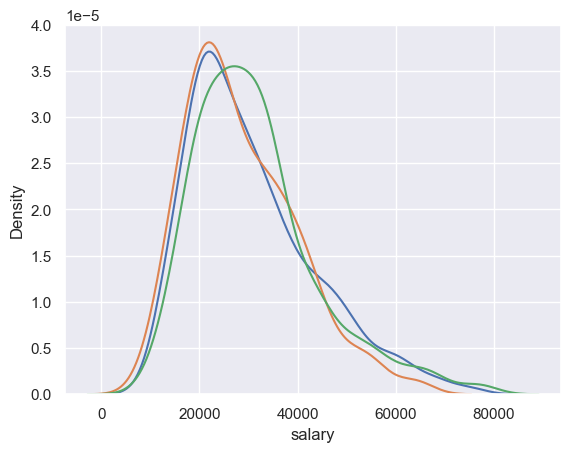

In [309]:
features=['skill', 'hazard', 'hours', 'production', 'prof_ohe', 'equip_ohe', 'prod_ty']
Xnew=df_experiment_metrics[features].values
ynew=df_experiment_metrics['salary'].values  # Labels
y_prednew=model.predict(Xnew)

# оценим метрику R-квадрат на валидационной выборке и напечатаем
r2 = r2_score(y_test, predictions)
print('Значение метрики R-квадрат: ', r2)
# гистограмма целевой переменной на train
sns.kdeplot(y_train)
# гистограмма целевой переменной на test
sns.kdeplot(y_test)
# гистограмма целевой переменной на experiment
sns.kdeplot(y_prednew)

In [310]:
y_prednew

array([20431.70093763, 28912.63054939, 34642.24756328, 36929.84873142,
       40079.0974655 , 41754.69372452, 36929.84873142, 36929.84873142,
       48787.03864909, 36929.84873142, 24446.03979194, 26877.2063625 ,
       29448.35510493, 32199.76170587, 34184.41884139, 34184.41884139,
       31492.99882919, 36929.84873142, 36530.78861661, 41151.62767519,
       34864.12914056, 33570.57977135, 45007.1693702 , 28650.32162694,
       37131.02021693, 37692.36707102, 43484.23253518, 31435.40668165,
       38950.94368119, 56352.87781769, 35990.73483593, 60003.9591342 ,
       45310.2110892 , 45310.2110892 , 40580.10638021, 65022.06906243,
       49849.32129498, 50214.96733396, 56261.61170825, 64445.42259552,
       41526.79846366, 52619.15875529, 39960.82916958, 50214.96733396,
       39190.69286232, 50214.96733396, 54075.79909317, 69775.36300547,
       54075.79909317, 41526.79846366, 52646.23068866, 67777.11785123,
       48785.39892945, 48785.39892945, 44914.33699106, 48785.39892945,
      

In [313]:
df_experiment_metrics['salary']=y_prednew
df_experiment_metrics.head()

C:\Users\se\AppData\Local\Temp\ipykernel_33048\383354924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment_metrics['salary']=y_prednew


,id_old,skill,hazard,hours,production,salary,prof_ohe,equip_ohe,prod_ty
0,1,2,1.0,180,1950,20431.700938,000000001,100000000,10.833333
1,2,2,1.0,228,1950,28912.630549,000000001,100000000,8.552632
2,3,2,1.0,252,1950,34642.247563,000000001,100000000,7.738095
3,4,2,3.3,240,1950,36929.848731,000000001,000000010,8.125000
4,5,2,3.3,252,1950,40079.097466,000001000,000000010,7.738095


Выгрузим результат в Excel

In [316]:
# DF TO EXCEL
# writer = ExcelWriter('Task_2.xlsx')
# df_experiment_metrics.to_excel(writer,'gaps_done_by_ML')

# DF TO CSV
df_experiment_metrics.to_csv('gaps_done_by_ML.csv', sep=',')

повторим то же самое с помощью 4-х факторной линейной регрессии

Coefficients:  [2.20847257e+00 2.30619455e+02 2.79178672e+03 2.41670851e+03]
Variance score: 0.9483514592461281


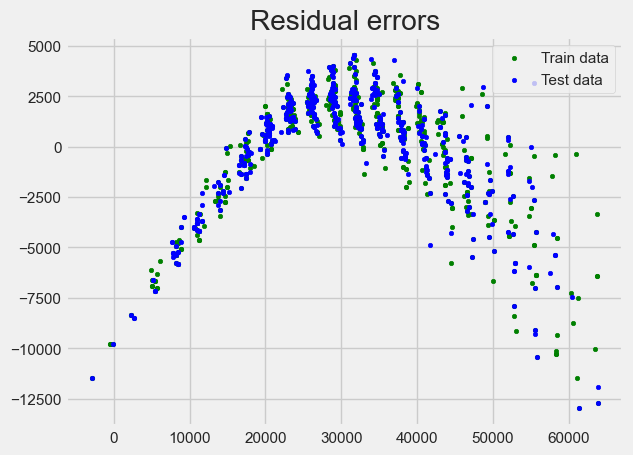

In [338]:
# load the dataset
features=['production', 'hours', 'skill', 'hazard']
X=df_train_metrics[features].values
y=df_train_metrics['salary'].values 
 
# splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
 
# create linear regression object
reg = linear_model.LinearRegression()
 
# train the model using the training sets
reg.fit(X_train, y_train)
 
# regression coefficients
print('Coefficients: ', reg.coef_)
 
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))
 
# plot for residual error
 
# setting plot style
plt.style.use('fivethirtyeight')
 
# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')
 
# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')
 
# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)
 
# plotting legend
plt.legend(loc='upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

In [329]:
features=['production', 'hours', 'skill', 'hazard']
X=df_experiment_metrics[features].values
y=df_experiment_metrics['salary'].values  # Labels
y_reg=reg.predict(X)
df_experiment_metrics['salary']=y_reg
# DF TO CSV
df_experiment_metrics.to_csv('gaps_done_by_LinReg_v2.csv', sep=',')
df_experiment_metrics.head()

C:\Users\se\AppData\Local\Temp\ipykernel_33048\3061097819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment_metrics['salary']=y_reg


,id_old,skill,hazard,hours,production,salary,prof_ohe,equip_ohe,prod_ty
0,1,2,1.0,180,1950,15981.322550,000000001,100000000,10.833333
1,2,2,1.0,228,1950,27051.056394,000000001,100000000,8.552632
2,3,2,1.0,252,1950,32585.923316,000000001,100000000,7.738095
3,4,2,3.3,240,1950,35376.919435,000000001,000000010,8.125000
4,5,2,3.3,252,1950,38144.352896,000001000,000000010,7.738095


## Выводы  
•	Часть строк по доходу не заполнена, заполните их  
Заполнили в отдельном датафрейме
•	Выявите формулу дохода в целом и его составных частей  
Выявили  
2       hours    0.804520  
3  production    0.091994  
0       skill    0.047548  
4    prof_ohe    0.040062  
1      hazard    0.009825  
5   equip_ohe    0.005192  
6     prod_ty    0.000859  

•	Проверьте, что данная формула объясняет доход с точностью до копейки


•	Выявите зависимости между составными частями дохода 